In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Downloading training images
!wget -cq http://imagenet.stanford.edu/internal/car196/cars_train.tgz

In [0]:
# Extracting training images 
!tar xvf cars_train.tgz 

cars_train/
cars_train/00001.jpg
cars_train/00002.jpg
cars_train/00003.jpg
cars_train/00004.jpg
cars_train/00005.jpg
cars_train/00006.jpg
cars_train/00007.jpg
cars_train/00008.jpg
cars_train/00009.jpg
cars_train/00010.jpg
cars_train/00011.jpg
cars_train/00012.jpg
cars_train/00013.jpg
cars_train/00014.jpg
cars_train/00015.jpg
cars_train/00016.jpg
cars_train/00017.jpg
cars_train/00018.jpg
cars_train/00019.jpg
cars_train/00020.jpg
cars_train/00021.jpg
cars_train/00022.jpg
cars_train/00023.jpg
cars_train/00024.jpg
cars_train/00025.jpg
cars_train/00026.jpg
cars_train/00027.jpg
cars_train/00028.jpg
cars_train/00029.jpg
cars_train/00030.jpg
cars_train/00031.jpg
cars_train/00032.jpg
cars_train/00033.jpg
cars_train/00034.jpg
cars_train/00035.jpg
cars_train/00036.jpg
cars_train/00037.jpg
cars_train/00038.jpg
cars_train/00039.jpg
cars_train/00040.jpg
cars_train/00041.jpg
cars_train/00042.jpg
cars_train/00043.jpg
cars_train/00044.jpg
cars_train/00045.jpg
cars_train/00046.jpg
cars_train/00047.jpg
c

In [0]:
# Dowloading test images
!wget -cq http://imagenet.stanford.edu/internal/car196/cars_test.tgz

In [51]:
# Extracting test images
!tar xvf cars_test.tgz 

cars_test/
cars_test/00001.jpg
cars_test/00002.jpg
cars_test/00003.jpg
cars_test/00004.jpg
cars_test/00005.jpg
cars_test/00006.jpg
cars_test/00007.jpg
cars_test/00008.jpg
cars_test/00009.jpg
cars_test/00010.jpg
cars_test/00011.jpg
cars_test/00012.jpg
cars_test/00013.jpg
cars_test/00014.jpg
cars_test/00015.jpg
cars_test/00016.jpg
cars_test/00017.jpg
cars_test/00018.jpg
cars_test/00019.jpg
cars_test/00020.jpg
cars_test/00021.jpg
cars_test/00022.jpg
cars_test/00023.jpg
cars_test/00024.jpg
cars_test/00025.jpg
cars_test/00026.jpg
cars_test/00027.jpg
cars_test/00028.jpg
cars_test/00029.jpg
cars_test/00030.jpg
cars_test/00031.jpg
cars_test/00032.jpg
cars_test/00033.jpg
cars_test/00034.jpg
cars_test/00035.jpg
cars_test/00036.jpg
cars_test/00037.jpg
cars_test/00038.jpg
cars_test/00039.jpg
cars_test/00040.jpg
cars_test/00041.jpg
cars_test/00042.jpg
cars_test/00043.jpg
cars_test/00044.jpg
cars_test/00045.jpg
cars_test/00046.jpg
cars_test/00047.jpg
cars_test/00048.jpg
cars_test/00049.jpg
cars_test

cars_train/00125.jpg
cars_train/07103.jpg
cars_train/07317.jpg
cars_train/02963.jpg
cars_train/02550.jpg
cars_train/01023.jpg
cars_train/00014.jpg
cars_train/07711.jpg
cars_train/01100.jpg


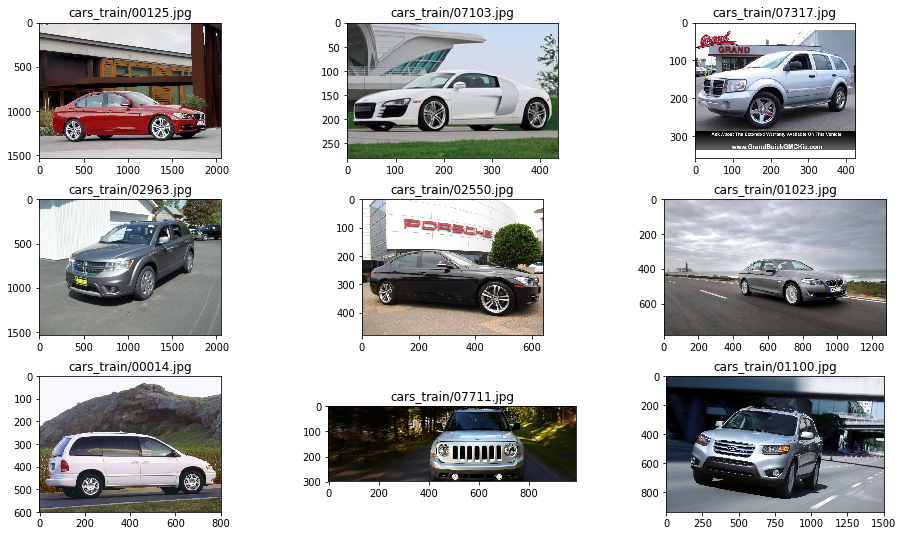

In [0]:
# Displaying a few training images
import matplotlib.pyplot as plt
from PIL import Image
import glob
count=0
fig=plt.figure(figsize=(16, 9))
for filename in glob.glob('cars_train/*.jpg'):
    img=Image.open(filename)
    count = count+1
    fig.add_subplot(3, 3, count)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    plt.imshow(img)
    plt.title(filename)
    print (filename)
    if count==9:
      break
      

cars_test/00125.jpg
cars_test/07103.jpg
cars_test/07317.jpg
cars_test/02963.jpg
cars_test/02550.jpg
cars_test/01023.jpg
cars_test/00014.jpg
cars_test/07711.jpg
cars_test/01100.jpg


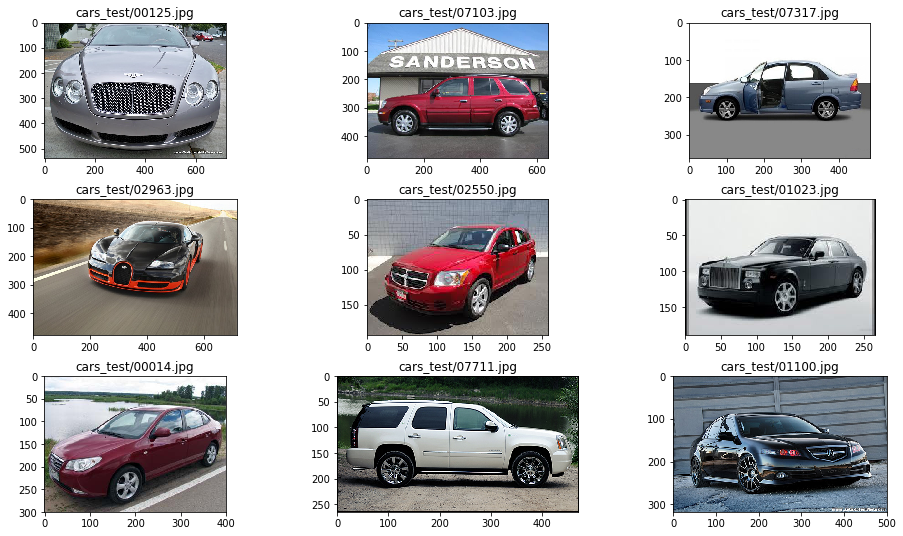

In [52]:
# Displaying a few test images
count=0
fig=plt.figure(figsize=(16, 9))
for filename in glob.glob('cars_test/*.jpg'):
    img=Image.open(filename)
    count = count+1
    fig.add_subplot(3, 3, count)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    plt.imshow(img)
    plt.title(filename)
    print (filename)
    if count==9:
      break
      

In [0]:
# Downloading devkit that includes class labels for training images and bounding boxes for all image
!wget -cq https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz

In [54]:
# Extracting devkit
!tar xvf car_devkit.tgz 

devkit/
devkit/cars_meta.mat
devkit/cars_train_annos.mat
devkit/cars_test_annos.mat
devkit/README.txt
devkit/train_perfect_preds.txt
devkit/eval_train.m


In [58]:
# Looking at different class labels
from scipy.io import loadmat
x = loadmat('devkit/cars_meta.mat')
x

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Dec 14 14:13:07 2013',
 '__version__': '1.0',
 'class_names': array([[array(['AM General Hummer SUV 2000'], dtype='<U26'),
         array(['Acura RL Sedan 2012'], dtype='<U19'),
         array(['Acura TL Sedan 2012'], dtype='<U19'),
         array(['Acura TL Type-S 2008'], dtype='<U20'),
         array(['Acura TSX Sedan 2012'], dtype='<U20'),
         array(['Acura Integra Type R 2001'], dtype='<U25'),
         array(['Acura ZDX Hatchback 2012'], dtype='<U24'),
         array(['Aston Martin V8 Vantage Convertible 2012'], dtype='<U40'),
         array(['Aston Martin V8 Vantage Coupe 2012'], dtype='<U34'),
         array(['Aston Martin Virage Convertible 2012'], dtype='<U36'),
         array(['Aston Martin Virage Coupe 2012'], dtype='<U30'),
         array(['Audi RS 4 Convertible 2008'], dtype='<U26'),
         array(['Audi A5 Coupe 2012'], dtype='<U18'),
         array(['Audi TTS Coupe 2012'], d